<a href="https://colab.research.google.com/github/neurorishika/PSST/blob/master/Tutorial/Day%205%20Optimal%20Mind%20Control/Day%205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%205%20Optimal%20Mind%20Control/Day%205.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

## Day 5: Optimal Mind Control

Welcome to Day 5! Now that we can simulate a model network of conductance-based neurons, we discuss the limitations of our approach and attempts to work around these issues.

### Memory Management

Using Python and TensorFlow allowed us to write code that is readable, parallizable and scalable across a variety of computational devices. However, our implementation is very memory intensive. The iterators in TensorFlow do not follow the normal process of memory allocation and garbage collection. Since, TensorFlow is designed to work on diverse hardware like GPUs, TPUs and distributed platforms, memory allocation is done adaptively during the TensorFlow session and not cleared until the Python kernel has stopped execution. The memory used increases linearly with time as the state matrix is computed recursively by the tf.scan function. The maximum memory used by the computational graph is 2 times the total state matrix size at the point when the computation finishes and copies the final data into the memory. The larger the network and longer the simulation, the larger the solution matrix. Each run is limited by the total available memory. For a system with a limited memory of K bytes, The length of a given simulation (L timesteps) of a given network (N differential equations) with 64-bit floating-point precision will follow:

$$2\times64\times L\times N=K$$ 

That is, for any given network, our maximum simulation length is limited. One way to improve our maximum length is to divide the simulation into smaller batches. There will be a small queuing time between batches, which will slow down our code by a small amount but we will be able to simulate longer times. Thus, if we split the simulation into K sequential batches, the maximum memory for the simulation becomes $(1+\frac{1}{K})$ times the total matrix size. Thus the memory relation becomes:  

$$\Big(1+\frac{1}{K}\Big)\times64\times L\times N=K$$ 

This way, we can maximize the length of out simulation that we can run in a single python kernel.

Let us implement this batch system for our 3 neuron feed-forward model.

### Implementing the Model

To improve the readability of our code we separate the integrator into a independent import module. The integrator code was placed in a file called tf integrator.py. The file must be present in the same directory as the implementation of the model.

Note: If you are using Jupyter Notebook, remember to remove the %matplotlib inline command as it is specific to jupyter.

#### Importing tf_integrator and other requirements

Once the Integrator is saved in tf_integrator.py in the same directory as the Notebook, we can start importing the essentials including the integrator.

**WARNING: If you are running this notebook using Kaggle, make sure you have logged in to your verified Kaggle account and enabled Internet Access for the kernel. For instructions on enabling Internet on Kaggle Kernels, visit: https://www.kaggle.com/product-feedback/63544**

In [1]:
#@markdown Import required files and code from previous tutorials

!wget --no-check-certificate \
  "https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%205%20Optimal%20Mind%20Control/tf_integrator.py" \
  -O "tf_integrator.py"
!wget --no-check-certificate \
  "https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%205%20Optimal%20Mind%20Control/call.py" \
  -O "call.py"
!wget --no-check-certificate \
  "https://raw.githubusercontent.com/neurorishika/PSST/master/Tutorial/Day%205%20Optimal%20Mind%20Control/run.py" \
  -O "run.py"

In [2]:
import numpy as np
import tf_integrator as tf_int
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

### Recall the Model

For implementing a Batch system, we do not need to change how we construct our model only how we execute it.

#### Step 1: Initialize Parameters and Dynamical Equations; Define Input

In [3]:
n_n = 3                            # Number of simultaneous neurons to simulate

sim_res = 0.01                     # Time Resolution of the Simulation
sim_time = 700                     # Length of the Simulation
t = np.arange(0,sim_time,sim_res)  # Time points at which to simulate the network

# Acetylcholine

ach_mat = np.zeros((n_n,n_n))       # Ach Synapse Connectivity Matrix
ach_mat[1,0]=1

## PARAMETERS FOR ACETYLCHLOLINE SYNAPSES ##

n_ach = int(np.sum(ach_mat))        # Number of Acetylcholine (Ach) Synapses 
alp_ach = [10.0]*n_ach              # Alpha for Ach Synapse
bet_ach = [0.2]*n_ach               # Beta for Ach Synapse
t_max = 0.3                         # Maximum Time for Synapse
t_delay = 0                         # Axonal Transmission Delay
A = [0.5]*n_n                       # Synaptic Response Strength
g_ach = [0.35]*n_n                  # Ach Conductance
E_ach = [0.0]*n_n                   # Ach Potential

# GABAa

gaba_mat = np.zeros((n_n,n_n))      # GABAa Synapse Connectivity Matrix
gaba_mat[2,1] = 1

## PARAMETERS FOR GABAa SYNAPSES ##

n_gaba = int(np.sum(gaba_mat))      # Number of GABAa Synapses
alp_gaba = [10.0]*n_gaba            # Alpha for GABAa Synapse
bet_gaba = [0.16]*n_gaba            # Beta for GABAa Synapse
V0 = [-20.0]*n_n                    # Decay Potential
sigma = [1.5]*n_n                   # Decay Time Constant
g_gaba = [0.8]*n_n                  # fGABA Conductance
E_gaba = [-70.0]*n_n                # fGABA Potential

## Storing Firing Thresholds ##
F_b = [0.0]*n_n                      # Fire threshold

def I_inj_t(t):
    """
    This function returns the external current to be injected into the network at any time step from the current_input matrix.

    Parameters:
    -----------
    t: float
        The time at which the current injection is being performed.
    """
    # Turn indices to integer and extract from matrix
    index = tf.cast(t/sim_res,tf.int32)
    return tf.constant(current_input.T,dtype=tf.float64)[index] 

## Acetylcholine Synaptic Current ##

def I_ach(o,V):
    """
    This function returns the synaptic current for the Acetylcholine (Ach) synapses for each neuron.

    Parameters:
    -----------
    o: float
        The fraction of open acetylcholine channels for each synapse.
    V: float
        The membrane potential of the postsynaptic neuron.
    """
    o_ = tf.constant([0.0]*n_n**2,dtype=tf.float64) # Initialize the flattened matrix to store the synaptic open fractions
    ind = tf.boolean_mask(tf.range(n_n**2),ach_mat.reshape(-1) == 1) # Get the indices of the synapses that exist
    o_ = tf.tensor_scatter_nd_update(o_,tf.reshape(ind,[-1,1]),o) # Update the flattened open fraction matrix
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n))) # Reshape and Transpose the matrix to be able to multiply it with the conductance matrix
    return tf.reduce_sum(tf.transpose((o_*(V-E_ach))*g_ach),1) # Calculate the synaptic current

## GABAa Synaptic Current ##

def I_gaba(o,V):
    """
    This function returns the synaptic current for the GABA synapses for each neuron.

    Parameters:
    -----------
    o: float
        The fraction of open GABA channels for each synapse.
    V: float
        The membrane potential of the postsynaptic neuron.
    """
    o_ = tf.constant([0.0]*n_n**2,dtype=tf.float64) # Initialize the flattened matrix to store the synaptic open fractions
    ind = tf.boolean_mask(tf.range(n_n**2),gaba_mat.reshape(-1) == 1) # Get the indices of the synapses that exist
    o_ = tf.tensor_scatter_nd_update(o_,tf.reshape(ind,[-1,1]),o) # Update the flattened open fraction matrix
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n))) # Reshape and Transpose the matrix to be able to multiply it with the conductance matrix
    return tf.reduce_sum(tf.transpose((o_*(V-E_gaba))*g_gaba),1) # Calculate the synaptic current

## Other Currents ##

def I_K(V, n):
    """
    This function determines the K-channel current.

    Parameters:
    -----------
    V: float
        The membrane potential.
    n: float 
        The K-channel gating variable n.
    """
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    """
    This function determines the Na-channel current.
    
    Parameters:
    -----------
    V: float
        The membrane potential.
    m: float
        The Na-channel gating variable m.
    h: float
        The Na-channel gating variable h.
    """
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    """
    This function determines the leak current.

    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    return g_L * (V - E_L)

def dXdt(X, t):
    """
    This function determines the derivatives of the membrane voltage and gating variables for n_n neurons.

    Parameters:
    -----------
    X: float
        The state vector given by the [V1,V2,...,Vn_n,m1,m2,...,mn_n,h1,h2,...,hn_n,n1,n2,...,nn_n] where 
            Vx is the membrane potential for neuron x
            mx is the Na-channel gating variable for neuron x 
            hx is the Na-channel gating variable for neuron x
            nx is the K-channel gating variable for neuron x.
    t: float
        The time points at which the derivatives are being evaluated.
    """
    V = X[:1*n_n]       # First n_n values are Membrane Voltage
    m = X[1*n_n:2*n_n]  # Next n_n values are Sodium Activation Gating Variables
    h = X[2*n_n:3*n_n]  # Next n_n values are Sodium Inactivation Gating Variables
    n = X[3*n_n:4*n_n]  # Next n_n values are Potassium Gating Variables
    o_ach = X[4*n_n : 4*n_n + n_ach] # Next n_ach values are Acetylcholine Synapse Open Fractions
    o_gaba = X[4*n_n + n_ach : 4*n_n + n_ach + n_gaba] # Next n_gaba values are GABAa Synapse Open Fractions
    fire_t = X[-n_n:]   # Last n_n values are the last fire times as updated by the modified integrator
    
    dVdt = (I_inj_t(t) - I_Na(V, m, h) - I_K(V, n) - I_L(V) - I_ach(o_ach,V) - I_gaba(o_gaba,V)) / C_m # The derivative of the membrane potential
    
    ## Updation for gating variables ##
    
    m0,tm,h0,th = Na_prop(V) # Calculate the dynamics of the Na-channel gating variables for all n_n neurons
    n0,tn = K_prop(V) # Calculate the dynamics of the K-channel gating variables for all n_n neurons

    dmdt = - (1.0/tm)*(m-m0) # The derivative of the Na-channel gating variable m for all n_n neurons
    dhdt = - (1.0/th)*(h-h0) # The derivative of the Na-channel gating variable h for all n_n neurons
    dndt = - (1.0/tn)*(n-n0) # The derivative of the K-channel gating variable n for all n_n neurons
    
    ## Updation for o_ach ##
    
    A_ = tf.constant(A,dtype=tf.float64) # Get the synaptic response strengths of the pre-synaptic neurons
    Z_ = tf.zeros(tf.shape(A_),dtype=tf.float64) # Create a zero matrix of the same size as A_
    
    T_ach = tf.where(tf.logical_and(tf.greater(t,fire_t+t_delay),tf.less(t,fire_t+t_max+t_delay)),A_,Z_)  # Find which synapses would have received an presynaptic spike in the past window and assign them the corresponding synaptic response strength
    T_ach = tf.multiply(tf.constant(ach_mat,dtype=tf.float64),T_ach) # Find the postsynaptic neurons that would have received an presynaptic spike in the past window
    T_ach = tf.boolean_mask(tf.reshape(T_ach,(-1,)),ach_mat.reshape(-1) == 1) # Get the pre-synaptic activation function for only the existing synapses
    
    do_achdt = alp_ach*(1.0-o_ach)*T_ach - bet_ach*o_ach  # Calculate the derivative of the open fraction of the acetylcholine synapses
     
    ## Updation for o_gaba ##
          
    T_gaba = 1.0/(1.0+tf.exp(-(V-V0)/sigma)) # Calculate the presynaptic activation function for all n_n neurons
    T_gaba = tf.multiply(tf.constant(gaba_mat,dtype=tf.float64),T_gaba) # Find the postsynaptic neurons that would have received an presynaptic spike in the past window
    T_gaba = tf.boolean_mask(tf.reshape(T_gaba,(-1,)),gaba_mat.reshape(-1) == 1) # Get the pre-synaptic activation function for only the existing synapses
    
    do_gabadt = alp_gaba*(1.0-o_gaba)*T_gaba - bet_gaba*o_gaba # Calculate the derivative of the open fraction of the GABAa synapses
    
    ## Updation for fire times ##
    
    dfdt = tf.zeros(tf.shape(fire_t),dtype=fire_t.dtype) # zero change in fire_t as it will be updated by the modified integrator
    
    out = tf.concat([dVdt,dmdt,dhdt,dndt,do_achdt,do_gabadt,dfdt],0) # Concatenate the derivatives of the membrane potential, gating variables, and open fractions
    return out


def K_prop(V):
    """
    This function determines the K-channel gating dynamics.

    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    T = 22 # Temperature
    phi = 3.0**((T-36.0)/10) # Temperature-correction factor
    V_ = V-(-50) # Voltage baseline shift
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0) # Alpha for the K-channel gating variable n
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0) # Beta for the K-channel gating variable n
    
    t_n = 1.0/((alpha_n+beta_n)*phi) # Time constant for the K-channel gating variable n
    n_0 = alpha_n/(alpha_n+beta_n) # Steady-state value for the K-channel gating variable n
    
    return n_0, t_n


def Na_prop(V):
    """
    This function determines the Na-channel gating dynamics.
    
    Parameters:
    -----------
    V: float
        The membrane potential.
    """
    T = 22 # Temperature 
    phi = 3.0**((T-36)/10)  # Temperature-correction factor
    V_ = V-(-50) # Voltage baseline shift
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0) # Alpha for the Na-channel gating variable m
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0) # Beta for the Na-channel gating variable m
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0) # Alpha for the Na-channel gating variable h
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0) # Beta for the Na-channel gating variable h
    
    t_m = 1.0/((alpha_m+beta_m)*phi) # Time constant for the Na-channel gating variable m
    t_h = 1.0/((alpha_h+beta_h)*phi) # Time constant for the Na-channel gating variable h
    
    m_0 = alpha_m/(alpha_m+beta_m) # Steady-state value for the Na-channel gating variable m
    h_0 = alpha_h/(alpha_h+beta_h) # Steady-state value for the Na-channel gating variable h
    
    return m_0, t_m, h_0, t_h


# Initializing the Parameters

C_m = [1.0]*n_n         # Membrane capacitances
g_K = [10.0]*n_n        # K-channel conductances
E_K = [-95.0]*n_n       # K-channel reversal potentials

g_Na = [100]*n_n        # Na-channel conductances
E_Na = [50]*n_n         # Na-channel reversal potentials

g_L = [0.15]*n_n        # Leak conductances
E_L = [-55.0]*n_n       # Leak reversal potentials

# Creating the Current Input
current_input= np.zeros((n_n,t.shape[0])) # The current input to the network
current_input[0,int(100/sim_res):int(200/sim_res)] = 2.5
current_input[0,int(300/sim_res):int(400/sim_res)] = 5.0
current_input[0,int(500/sim_res):int(600/sim_res)] = 7.5

#### Step 2: Define the Initial Condition of the Network and Add some Noise to the initial conditions

In [4]:
# Initializing the State Vector and adding 1% noise
state_vector = [-71]*n_n+[0,0,0]*n_n+[0]*n_ach+[0]*n_gaba+[-9999999]*n_n
state_vector = np.array(state_vector)
state_vector = state_vector + 0.01*state_vector*np.random.normal(size=state_vector.shape)

#### Step 3: Splitting Time Series into independent batches and Run Each Batch Sequentially

Since we will be dividing the computation into batches, we have to split the time array such that for each new call, the final state vector of the last batch will be the initial condition for the current batch. The function $np.array\_split()$ splits the array into non-overlapping vectors. Therefore, we append the last time of the previous batch to the beginning of the current time array batch.

*Note: The following cell can take a few minutes to run the simulation depending on your device.*

In [5]:
# Define the Number of Batches
n_batch = 2

# Split t array into batches using numpy
t_batch = np.array_split(t,n_batch)

# Iterate over the batches of time array
for n,i in enumerate(t_batch):
    
    # Inform start of Batch Computation
    print("Batch",(n+1),"Running...",end="")
    
    # In np.array_split(), the split edges are present in only one array and since 
    # our initial vector to successive calls is corresposnding to the last output
    # our first element in the later time array should be the last element of the 
    # previous output series, Thus, we append the last time to the beginning of 
    # the current time array batch.
    if n>0:
        i = np.append(i[0]-sim_res,i)
    
    # Set state_vector as the initial condition
    init_state = tf.constant(state_vector, dtype=tf.float64)
    # Create the Integrator computation graph over the current batch of t array
    tensor_state = tf_int.odeint(dXdt, init_state, i, n_n, F_b)
    
    # Initialize variables and run session
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        state = sess.run(tensor_state)
        sess.close()
    
    # Reset state_vector as the last element of output
    state_vector = state[-1,:]
    
    # Save the output of the simulation to a binary file
    np.save("part_"+str(n+1),state)

    # Clear output
    state=None
    
    print("Finished")

Batch 1 Running...Finished
Batch 2 Running...Finished


#### Putting the Output Together

The output from our batch implementation is a set of binary files that store parts of our total simulation. To get the overall output we have to stitch them back together.

In [6]:
overall_state = []

# Iterate over the generated output files
for n,i in enumerate(["part_"+str(n+1)+".npy" for n in range(n_batch)]):
    
    # Since the first element in the series was the last output, we remove them
    if n>0:
        overall_state.append(np.load(i)[1:,:])
    else:
        overall_state.append(np.load(i))

# Concatenate all the matrix to get a single state matrix
overall_state = np.concatenate(overall_state)

#### Visualizing the Overall Data
Finally, we plot the same voltage traces of the 3 neurons from Day 4 as a Voltage vs Time heatmap. While this visualization may seem unnecessary for just 3 neurons, it becomes an useful tool when on visualizes the dynamics of a large network of neurons as illustrated in the Example Implementation of the Locust Antennal Lobe. 

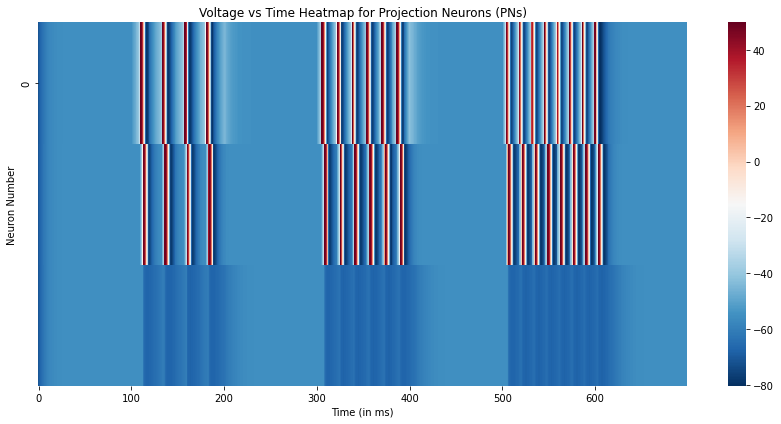

In [7]:
# Plot the voltage traces of the three neurons
plt.figure(figsize=(12,6))    
sns.heatmap(overall_state[::100,:3].T,xticklabels=100,yticklabels=5,cmap='RdBu_r')
plt.xlabel("Time (in ms)")
plt.ylabel("Neuron Number")
plt.title("Voltage vs Time Heatmap for Projection Neurons (PNs)")
plt.tight_layout()
plt.show()

By this method, we have maximized the usage of our available memory but we can go further and develop a method to allow indefinitely long simulation. The issue behind this entire algorithm is that the memory is not cleared until the python kernel finishes. One way to overcome this is to save the parameters of the model (such as connectivity matrix) and the state vector in a file, and start a new python kernel from a python script to compute successive batches. This way after each large batch, the memory gets cleaned. By combining the previous batch implementation and this system, we can maximize our computability.

### Implementing a Runner and a Caller

Firstly, we have to create an implementation of the model that takes in previous input as current parameters. Thus, we create a file, which we call "run.py" that takes an argument ie. the current batch number. The implementation for "run.py" is mostly same as the above model but there is a small difference.

When the batch number is 0, we initialize all variable parameters and save them, but otherwise we use the saved values. The parameters we save include: Acetylcholine Matrix, GABAa Matrix and Final/Initial State Vector. It will also save the files with both batch number and sub-batch number listed.

The time series will be created and split initially by the caller, which we call "call.py", and stored in a file. Each execution of the Runner will extract its relevant time series and compute on it.

#### Implementing the Runner code

"run.py" is essentially identical to the batch-implemented model we developed above with the changes described below:


```
# Additional Imports #

import sys

# Duration of Simulation #

# t = np.arange(0,sim_time,sim_res)      
t = np.load("time.npy",allow_pickle=True)[int(sys.argv[1])] # get first argument to run.py

# Connectivity Matrix Definitions #

if sys.argv[1] == '0':
    ach_mat = np.zeros((n_n,n_n)) # Ach Synapse Connectivity Matrix
    ach_mat[1,0]=1                # If connectivity is random, once initialized it will be the same.
    np.save("ach_mat",ach_mat)
else:
    ach_mat = np.load("ach_mat.npy")
    
if sys.argv[1] == '0':
    gaba_mat = np.zeros((n_n,n_n)) # GABAa Synapse Connectivity Matrix
    gaba_mat[2,1] = 1              # If connectivity is random, once initialized it will be the same.
    np.save("gaba_mat",gaba_mat)
else:
    gaba_mat = np.load("gaba_mat.npy")

# Current Input Definition #
    
if sys.argv[1] == '0':
    current_input= np.zeros((n_n,int(sim_time/sim_res)))
    current_input[0,int(100/sim_res):int(200/sim_res)] = 2.5
    current_input[0,int(300/sim_res):int(400/sim_res)] = 5.0
    current_input[0,int(500/sim_res):int(600/sim_res)] = 7.5
    np.save("current_input",current_input)
else:
    current_input = np.load("current_input.npy")
    
# State Vector Definition #

if sys.argv[1] == '0':
    state_vector = [-71]*n_n+[0,0,0]*n_n+[0]*n_ach+[0]*n_gaba+[-9999999]*n_n
    state_vector = np.array(state_vector)
    state_vector = state_vector + 0.01*state_vector*np.random.normal(size=state_vector.shape)
    np.save("state_vector",state_vector)
else:
    state_vector = np.load("state_vector.npy")

# Saving of Output #

# np.save("part_"+str(n+1),state)
np.save("batch"+str(int(sys.argv[1])+1)+"_part_"+str(n+1),state)
```



#### Implementing the Caller code

The caller will create the time series, split it and use python subprocess module to call "run.py" with appropriate arguments. The code for "call.py" is given below.

```
from subprocess import call
import numpy as np

total_time = 700
n_splits = 2
time = np.split(np.arange(0,total_time,0.01),n_splits)

# Append the last time point to the beginning of the next batch
for n,i in enumerate(time):
    if n>0:
        time[n] = np.append(i[0]-0.01,i)

np.save("time",time)

# call successive batches with a new python subprocess and pass the batch number
for i in range(n_splits):
    call(['python','run.py',str(i)])

print("Simulation Completed.")
```

#### Using call.py

*Note: The following cell can take a few minutes to run the simulation depending on your device.*

In [8]:
!python call.py

Batch 1 Running...Finished
Batch 2 Running...Finished

C:\Users\labadmin\.conda\envs\psst\lib\site-packages\numpy\lib\npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
2022-02-19 14:59:57.587249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-02-19 14:59:57.587541: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-19 15:00:02.317524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-02-19 15:00:02.317838: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2


Batch 1 Running...Finished
Batch 2 Running...Finished
Simulation Completed.


#### Combining all Data

Just like we merged all the batches, we merge all the sub-batches and batches.

In [9]:
n_splits = 2
n_batch = 2

overall_state = []

# Iterate over the generated output files
for n,i in enumerate(["batch"+str(x+1) for x in range(n_splits)]):
    for m,j in enumerate(["_part_"+str(x+1)+".npy" for x in range(n_batch)]):
    
        # Since the first element in the series was the last output, we remove them
        if n>0 and m>0:
            overall_state.append(np.load(i+j)[1:,:])
        else:
            overall_state.append(np.load(i+j))

# Concatenate all the matrix to get a single state matrix
overall_state = np.concatenate(overall_state)

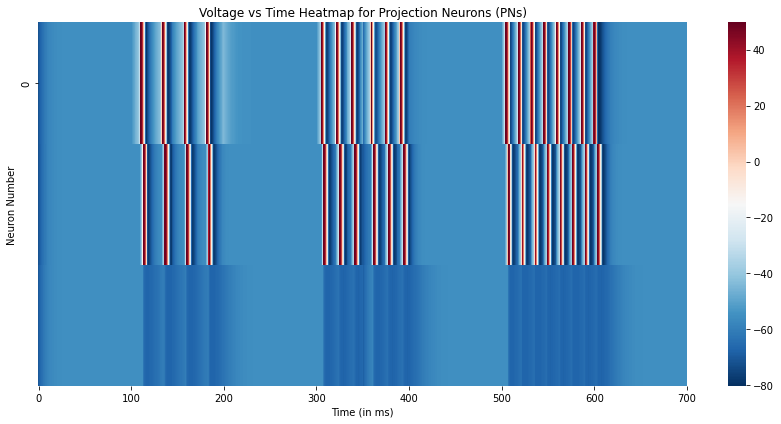

In [10]:
# Plot the simulation results
plt.figure(figsize=(12,6))
sns.heatmap(overall_state[::100,:3].T,xticklabels=100,yticklabels=5,cmap='RdBu_r')
plt.xlabel("Time (in ms)")
plt.ylabel("Neuron Number")
plt.title("Voltage vs Time Heatmap for Projection Neurons (PNs)")
plt.tight_layout()
plt.show()